# Preliminary Look and Clustering News Sources

Junita Sirait

I would like to cluster news sources based on in which subreddits they appear. First I will use k-means algorithm, then I will try out other algorithms such as DBSCAN and others. 

In [74]:
!pip install kneed

You should consider upgrading via the 'c:\users\user200803\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [1]:
import json
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from sklearn import preprocessing

from sklearn.metrics import silhouette_score
from kneed import KneeLocator

from scipy.interpolate import make_interp_spline, BSpline

from sklearn.decomposition import PCA

In [2]:
with open("ns_subreddit.json", "r", encoding = "utf-8") as infile:
    ns_subreddit = json.load(infile)

How many news sources are there?

In [3]:
num_ns = len(ns_subreddit)
num_ns

3686

Let's see the data structure for `nytimes.com`

In [4]:
Counter(ns_subreddit['nytimes.com']).most_common(20)

[('nytimes', 5322),
 ('NYTauto', 3798),
 ('AutoNewspaper', 3788),
 ('TrendingQuickTVnews', 1454),
 ('politics', 775),
 ('news', 435),
 ('u_NumerousRow', 322),
 ('worldnews', 261),
 ('Coronavirus', 243),
 ('NoFilterNews', 211),
 ('FreshNewsToday', 198),
 ('u_somuchinfook', 197),
 ('u_Music908', 188),
 ('ScienceFeed', 170),
 ('autotldr', 167),
 ('AnythingGoesNews', 155),
 ('bitstreetpost', 132),
 ('neoliberal', 122),
 ('badgovnofreedom', 109),
 ('NoNewNormal', 77)]

For each news source, let's count in how many subreddits they appear

In [5]:
subreddit_count = dict()
for ns in ns_subreddit:
    subreddit_count[ns] = len(ns_subreddit[ns].keys())

`subreddit_count` stores in how many subreddits each news source appears.

In [6]:
subreddit_count['nytimes.com']

2174

In [7]:
subreddit_count_freq = dict(Counter(subreddit_count.values()).most_common())
subreddit_count_freq

{1: 675,
 2: 440,
 3: 315,
 4: 233,
 5: 162,
 6: 135,
 7: 132,
 8: 119,
 9: 95,
 10: 89,
 13: 69,
 12: 66,
 11: 62,
 17: 45,
 16: 44,
 14: 41,
 18: 37,
 15: 37,
 23: 37,
 20: 33,
 22: 32,
 19: 29,
 21: 25,
 27: 25,
 26: 25,
 25: 24,
 24: 19,
 44: 18,
 34: 18,
 28: 17,
 45: 17,
 33: 17,
 30: 16,
 29: 15,
 41: 15,
 40: 14,
 32: 14,
 31: 13,
 36: 13,
 39: 13,
 51: 11,
 61: 10,
 46: 10,
 50: 10,
 37: 9,
 38: 9,
 53: 8,
 42: 8,
 62: 7,
 43: 7,
 72: 7,
 60: 6,
 81: 6,
 56: 6,
 113: 6,
 35: 6,
 64: 6,
 55: 6,
 58: 5,
 47: 5,
 48: 5,
 117: 5,
 52: 5,
 73: 5,
 104: 5,
 105: 5,
 57: 5,
 63: 5,
 66: 5,
 67: 4,
 82: 4,
 83: 4,
 94: 4,
 85: 4,
 49: 4,
 78: 4,
 71: 4,
 86: 3,
 76: 3,
 54: 3,
 223: 3,
 202: 3,
 59: 3,
 89: 3,
 154: 3,
 125: 3,
 100: 3,
 84: 3,
 88: 3,
 92: 3,
 70: 3,
 65: 3,
 99: 2,
 102: 2,
 159: 2,
 146: 2,
 75: 2,
 74: 2,
 331: 2,
 114: 2,
 193: 2,
 150: 2,
 69: 2,
 90: 2,
 222: 2,
 98: 2,
 106: 2,
 149: 2,
 168: 2,
 80: 2,
 192: 2,
 108: 2,
 132: 2,
 361: 2,
 153: 2,
 95: 2,
 128

`subreddit_count_freq` keeps track of how many news sources appear in *n* subreddits for all possible *n*.

In [9]:
max(subreddit_count_freq.keys())

2174

Wow! There is a news source that appears in 2174 subreddits. This is `nytimes.com`.

In [10]:
for ns in ns_subreddit:
    count = subreddit_count[ns]
    if count > 1000:
        print(f"{ns} appears in {count} subreddits.")

cnbc.com appears in 1247 subreddits.
bbc.co.uk appears in 1095 subreddits.
reuters.com appears in 1538 subreddits.
nytimes.com appears in 2174 subreddits.
nbcnews.com appears in 1056 subreddits.
cnn.com appears in 1510 subreddits.
apnews.com appears in 1193 subreddits.
linkedin.com appears in 1506 subreddits.
washingtonpost.com appears in 1306 subreddits.
anchor.fm appears in 1049 subreddits.


Not sure why `cnbc.com` appears in so many subreddits. Canada! Linkedin appears a lot too, people sharing about themselves? But anonymous?

## Cluster Try Out

First, I make a list of subreddits with fixed order.

In [11]:
with open("subreddit_ns.json", "r", encoding = "utf-8") as infile:
    subreddit_ns = json.load(infile)

In [12]:
subreddits = list(subreddit_ns.keys())
len(subreddits)

20755

There are 20755 subreddits.

In [14]:
subreddits[:10]

['razorbacks',
 'todayilearned',
 'nofeenews',
 'newsokur',
 'Ecatepec',
 'AntiHateCommunities',
 'anime',
 'worldnews',
 'TickerNews',
 'DeFiBuzz']

If I should order them later, I can do so.

Then, for each news source, I create a list of length 20755 (# subreddits), and the values would be the count of how many times that news source appears in subreddit index *i*, where the index is based on the list `subreddits`.

In [15]:
ns_sr_rep = dict()
for ns in ns_subreddit:
    ns_sr_rep[ns] = [ns_subreddit[ns][subreddits[idx]] if subreddits[idx] in ns_subreddit[ns] else 0 for idx in range(len(subreddits))]

Let's see one example of representation for `nytimes.com`.

In [16]:
ns_sr_rep['nytimes.com']

[0,
 61,
 0,
 0,
 0,
 0,
 0,
 261,
 0,
 1,
 0,
 1454,
 0,
 0,
 3788,
 167,
 435,
 32,
 1,
 22,
 61,
 0,
 0,
 8,
 0,
 0,
 1,
 6,
 775,
 17,
 0,
 6,
 243,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 4,
 2,
 0,
 0,
 0,
 0,
 0,
 62,
 0,
 0,
 4,
 1,
 1,
 0,
 0,
 14,
 2,
 0,
 5,
 0,
 1,
 0,
 0,
 5,
 0,
 0,
 0,
 8,
 0,
 0,
 0,
 0,
 15,
 0,
 1,
 0,
 31,
 0,
 0,
 0,
 0,
 0,
 22,
 0,
 47,
 0,
 12,
 197,
 47,
 4,
 1,
 0,
 8,
 0,
 4,
 14,
 0,
 0,
 6,
 4,
 0,
 0,
 109,
 4,
 2,
 2,
 0,
 13,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 2,
 0,
 1,
 2,
 77,
 4,
 0,
 0,
 3798,
 63,
 7,
 0,
 21,
 8,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 20,
 0,
 0,
 0,
 1,
 1,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 1,
 6,
 2,
 0,
 0,
 3,
 0,
 0,
 1,
 33,
 0,
 0,
 0,
 0,
 1,
 0,
 3,
 0,
 1,
 0,
 0,
 4,
 72,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 2,
 4,
 1,
 1,
 0,
 7,
 5,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 14,
 37,
 0,
 0,
 0,
 0,
 15,
 1,
 9,
 0,
 0,
 0,
 0,
 7,
 0,
 1,
 0,
 3,
 198,
 0,
 9,
 0,
 0,
 0,
 0,
 0,
 0,
 39,
 0,
 27,
 9,
 3,
 1,
 0,
 0,
 0,
 0,
 0,
 0,


Now, I will cast those list representation values to be numpy arrays so I can preprocess them easily. Further, I will normalize each array.

In [17]:
preprocessing.normalize(np.array([[1,100,2,3]]))

array([[0.00999301, 0.99930073, 0.01998601, 0.02997902]])

In [18]:
scaler = StandardScaler()
scaler.fit_transform(np.array([[1,100,2,3]]))

array([[0., 0., 0., 0.]])

Now I'm thinking, should I *normalize* or *standardize*?

In [19]:
for ns in ns_sr_rep:
    rep = ns_sr_rep[ns]
    ns_sr_rep[ns] = preprocessing.normalize(np.array([rep]))

Let's check for `nytimes.com`.

In [20]:
ns_sr_rep['nytimes.com'][0]

array([0.        , 0.00783304, 0.        , ..., 0.        , 0.        ,
       0.        ])

## K-Means

First, I need to find optimum `k`.

In [21]:
kmeans = KMeans(init = "random",
               n_clusters = 5,
               n_init = 10,
               max_iter = 100)

Freezing the list for representations and the news sources.

In [25]:
items = list(ns_sr_rep.items())
items[0]

('espn.com',
 array([[0.01245995, 0.00249199, 0.000623  , ..., 0.        , 0.        ,
         0.        ]]))

In [26]:
ns_repr, ns_fixed = np.array([v[1][0] for v in items]), list([v[0] for v in items])

In [27]:
kmeans.fit([v[0] for v in ns_sr_rep.values()])

KMeans(init='random', max_iter=100, n_clusters=5)

In [28]:
for i,ns in enumerate(ns_fixed):
    if (ns_sr_rep[ns][0] == ns_repr[i]).all():
        pass
    else:
        print("False")
print("True")

True


In [29]:
kmeans.inertia_

3439.279659857618

In [30]:
kmeans.n_iter_

14

In [31]:
kmeans.labels_[:10]

array([3, 0, 0, 3, 0, 0, 0, 3, 0, 0])

**Choosing the appropriate number of clusters**

1. Elbow method

In [61]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
}

In [65]:
sse = []
for k in range(1,20):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(ns_repr)
    sse.append(kmeans.inertia_)
    print(f"have done {k} rounds, current sse is {sse}")

have done 1 rounds, current sse is [3645.791550610924]
have done 2 rounds, current sse is [3645.791550610924, 3543.7826439412133]
have done 3 rounds, current sse is [3645.791550610924, 3543.7826439412133, 3494.3439505022857]
have done 4 rounds, current sse is [3645.791550610924, 3543.7826439412133, 3494.3439505022857, 3459.764869218102]
have done 5 rounds, current sse is [3645.791550610924, 3543.7826439412133, 3494.3439505022857, 3459.764869218102, 3435.958188120594]
have done 6 rounds, current sse is [3645.791550610924, 3543.7826439412133, 3494.3439505022857, 3459.764869218102, 3435.958188120594, 3404.826061905686]
have done 7 rounds, current sse is [3645.791550610924, 3543.7826439412133, 3494.3439505022857, 3459.764869218102, 3435.958188120594, 3404.826061905686, 3374.629163479639]
have done 8 rounds, current sse is [3645.791550610924, 3543.7826439412133, 3494.3439505022857, 3459.764869218102, 3435.958188120594, 3404.826061905686, 3374.629163479639, 3379.6703640936303]
have done 9 ro

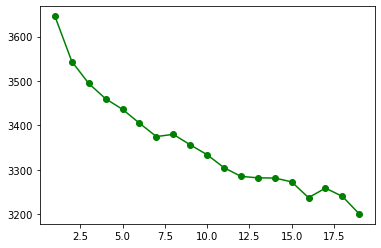

In [70]:
plt.plot(range(1,20),sse,"go-")

In [71]:
for k in range(20,41):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(ns_repr)
    sse.append(kmeans.inertia_)
    print(f"have done {k} rounds, current sse is {sse}")

have done 20 rounds, current sse is [3645.791550610924, 3543.7826439412133, 3494.3439505022857, 3459.764869218102, 3435.958188120594, 3404.826061905686, 3374.629163479639, 3379.6703640936303, 3356.086493295629, 3333.704027565556, 3304.5870223099037, 3284.966883295817, 3281.633068658084, 3281.2210982386728, 3272.5664906397355, 3236.9730518882966, 3258.5049955557242, 3239.836945139774, 3200.3322782637665, 3212.7230032328457]
have done 21 rounds, current sse is [3645.791550610924, 3543.7826439412133, 3494.3439505022857, 3459.764869218102, 3435.958188120594, 3404.826061905686, 3374.629163479639, 3379.6703640936303, 3356.086493295629, 3333.704027565556, 3304.5870223099037, 3284.966883295817, 3281.633068658084, 3281.2210982386728, 3272.5664906397355, 3236.9730518882966, 3258.5049955557242, 3239.836945139774, 3200.3322782637665, 3212.7230032328457, 3152.7196174683286]
have done 22 rounds, current sse is [3645.791550610924, 3543.7826439412133, 3494.3439505022857, 3459.764869218102, 3435.958188

have done 35 rounds, current sse is [3645.791550610924, 3543.7826439412133, 3494.3439505022857, 3459.764869218102, 3435.958188120594, 3404.826061905686, 3374.629163479639, 3379.6703640936303, 3356.086493295629, 3333.704027565556, 3304.5870223099037, 3284.966883295817, 3281.633068658084, 3281.2210982386728, 3272.5664906397355, 3236.9730518882966, 3258.5049955557242, 3239.836945139774, 3200.3322782637665, 3212.7230032328457, 3152.7196174683286, 3199.442792087385, 3160.992753363927, 3166.520388751286, 3124.0689586139056, 3155.4250096591954, 3129.4043371435127, 3111.862124435717, 3114.0614609881727, 3092.7004063246295, 3080.492706138238, 3056.96168852659, 3083.5561133415936, 3042.4769512849966, 3081.1743673436467]
have done 36 rounds, current sse is [3645.791550610924, 3543.7826439412133, 3494.3439505022857, 3459.764869218102, 3435.958188120594, 3404.826061905686, 3374.629163479639, 3379.6703640936303, 3356.086493295629, 3333.704027565556, 3304.5870223099037, 3284.966883295817, 3281.633068

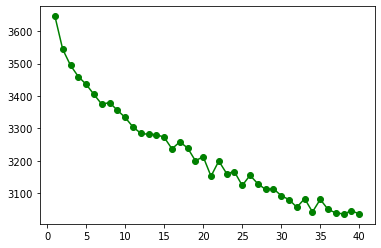

In [72]:
plt.plot(range(1,41),sse,"go-")

In [76]:
kl = KneeLocator(range(1,41), sse, curve="convex", direction="decreasing")

In [77]:
kl.elbow

7

**Using Silhouette Coefficient**

In [79]:
sc = []
new_sse = []
for k in range(2,51):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(ns_repr)
    score = silhouette_score(ns_repr, kmeans.labels_)
    sc.append(score)
    new_sse.append(kmeans.inertia_)
    print("step {}".format(k))

step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29
step 30
step 31
step 32
step 33
step 34
step 35
step 36
step 37
step 38
step 39
step 40
step 41
step 42
step 43
step 44
step 45
step 46
step 47
step 48
step 49
step 50


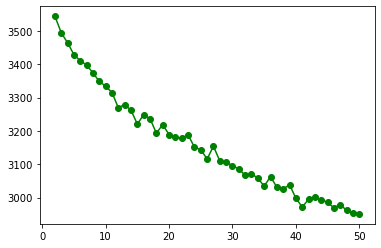

In [83]:
# for sse
plt.plot(range(2,51), new_sse, "go-")

In [86]:
kl_new = KneeLocator(range(2,51), new_sse, curve="convex", direction="decreasing")
kl_new.elbow

12

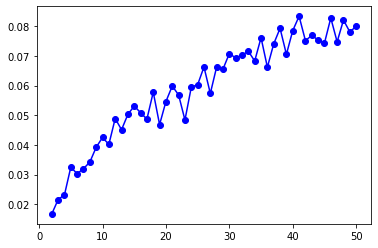

In [87]:
# for silhouette coefficient
plt.plot(range(2,51), sc, "bo-")

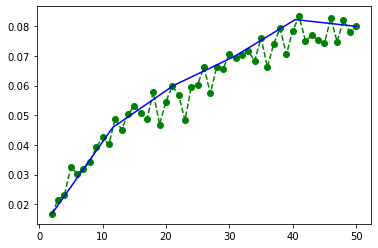

In [94]:


spl = make_interp_spline(range(2,51), sc, k=3)  # type: BSpline

xs = np.linspace(2, 50, 6)
ys = spl(xs)

plt.plot(range(2,51), sc, "go--")
plt.plot(xs, ys, "b-")

Let's choose k = 12

In [96]:
kmeans = KMeans(n_clusters = 12, init="k-means++", n_init = 50, max_iter = 500)
kmeans.fit(ns_repr)

KMeans(max_iter=500, n_clusters=12, n_init=50)

In [102]:
dir(kmeans)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_algorithm',
 '_check_n_features',
 '_check_params',
 '_check_test_data',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_n_init',
 '_n_threads',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_tol',
 '_transform',
 '_validate_data',
 'algorithm',
 'cluster_centers_',
 'copy_x',
 'fit',
 'fit_predict',
 'fit_transform',
 'get_params',
 'inertia_',
 'init',
 'labels_',
 'max_iter',
 'n_clusters',
 'n_features_in_',
 'n_init',
 'n_iter_',
 'n_jobs',
 'precompute_distances',
 'predict',
 'random_state',
 'score',
 'set_params',
 'tol',
 'transform',
 '

In [103]:
kmeans.labels_

array([11,  0,  0, ...,  0,  0,  0])

In [104]:
set(kmeans.labels_)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}

In [100]:
pca = PCA(n_components = 2)

In [101]:
pca_2d = pca.fit_transform(ns_repr)
pca_2d

array([[-0.05943236,  0.06733374],
       [-0.05219235, -0.05024858],
       [-0.01116583, -0.04044385],
       ...,
       [-0.04954164, -0.0579535 ],
       [-0.05170261, -0.06154585],
       [-0.0506029 , -0.0604102 ]])

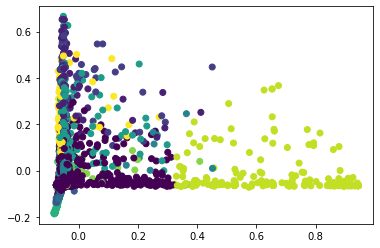

In [107]:
plt.scatter([v[0] for v in pca_2d], [v[1] for v in pca_2d], c = kmeans.labels_)

**Let's investigate each cluster**

In [136]:
len(ns_subreddit)

3686

In [112]:
clustered = defaultdict(list)
for idx,ns in enumerate(ns_fixed):
    c = kmeans.labels_[idx]
    clustered[c].append(ns)

In [116]:
print([len(clustered[i]) for i in range(12)])

[2572, 132, 120, 81, 46, 84, 202, 63, 54, 31, 201, 100]


Hmm out of 3.6k news sources, 2.5 is in one single cluster. Perhaps I should increase the number of clusters.

In [129]:
clustered[1]

['jsonline.com',
 'ajc.com',
 'washingtonpost.com',
 'lawandcrime.com',
 'texastribune.org',
 'politico.com',
 'al.com',
 'houstonchronicle.com',
 'foxbangor.com',
 'talkingpointsmemo.com',
 'newrepublic.com',
 'msnbc.com',
 'vox.com',
 'mediaite.com',
 'nextgov.com',
 'buzzfeednews.com',
 'wktv.com',
 'cbs19.tv',
 'slate.com',
 'oklahoman.com',
 'nymag.com',
 'theatlantic.com',
 'democracynow.org',
 '5newsonline.com',
 '12news.com',
 'jacobinmag.com',
 'newyorker.com',
 'azcentral.com',
 'axios.com',
 'dailydot.com',
 'tennessean.com',
 'inthesetimes.com',
 'fastcompany.com',
 'peoplesworld.org',
 'gpb.org',
 'courthousenews.com',
 'sacurrent.com',
 'bostonglobe.com',
 'theroot.com',
 'wpsdlocal6.com',
 'snopes.com',
 'wcyb.com',
 'wlrn.org',
 'theintelligencer.com',
 'khou.com',
 'middletownpress.com',
 'insider.com',
 'texasmonthly.com',
 'palmbeachpost.com',
 'techdirt.com',
 'lawfareblog.com',
 'rawstory.com',
 'orlandoweekly.com',
 'progressive.org',
 'postandcourier.com',
 'dail

Some big names in cluster 1: politico.com, msnbc.com, washingtonpost.com, newyorker.com.

Some geographical: texastribune.com, houstonchronicle.com, azcentral.com, tennessean.com.

In [130]:
clustered[2]

['ksnblocal4.com',
 'wbng.com',
 'kutv.com',
 'mynbc15.com',
 'nbc12.com',
 'kxxv.com',
 'kptv.com',
 'naplesnews.com',
 'winknews.com',
 'news8000.com',
 'ksat.com',
 'click2houston.com',
 '1011now.com',
 'wtap.com',
 'krcrtv.com',
 'wfaa.com',
 'cincinnati.com',
 'wate.com',
 'actionnewsnow.com',
 'nbcmiami.com',
 'wbtv.com',
 'weartv.com',
 'wkbw.com',
 'unionleader.com',
 'nbcchicago.com',
 'news4jax.com',
 'clickorlando.com',
 'kait8.com',
 'wlbt.com',
 'abc30.com',
 'live5news.com',
 'fox19.com',
 'azfamily.com',
 'wdbj7.com',
 'abc3340.com',
 '14news.com',
 'wreg.com',
 'abc10.com',
 'wacotrib.com',
 'nbcdfw.com',
 'mv-voice.com',
 'kplctv.com',
 'turnto10.com',
 'wmbfnews.com',
 'wect.com',
 'ktiv.com',
 'katc.com',
 'beaconjournal.com',
 'cleveland19.com',
 'wwltv.com',
 'nbc29.com',
 'wptv.com',
 'kcbd.com',
 'kltv.com',
 'walb.com',
 'wkow.com',
 'wistv.com',
 'wset.com',
 'foxcarolina.com',
 'wsls.com',
 'yakimaherald.com',
 'wsfa.com',
 'wafb.com',
 'daytondailynews.com',


Some tv: kutv.com, kptv.com, wbtv.com, weartv.com.

Gray Media Group: kait8.com, 14news.com, live5news.com, kcbd.com, etc

In [131]:
clustered[3]

['stern.de',
 'skysports.com',
 'football.london',
 'as.com',
 'sueddeutsche.de',
 'theathletic.com',
 'abola.pt',
 'spiegel.de',
 'derstandard.at',
 'kicker.de',
 'welt.de',
 'bild.de',
 'fourfourtwo.com',
 'wiwo.de',
 'golem.de',
 'stuttgarter-nachrichten.de',
 'focus.de',
 'rp-online.de',
 'tagesspiegel.de',
 'br.de',
 'faz.net',
 'morgenpost.de',
 'futurezone.at',
 'mdr.de',
 'marca.com',
 'tag24.de',
 'pcwelt.de',
 'n-tv.de',
 'chroniclelive.co.uk',
 'ndr.de',
 'heise.de',
 'sportske.jutarnji.hr',
 'talksport.com',
 'mundodeportivo.com',
 'beinsports.com',
 '20min.ch',
 'football365.com',
 'ondacero.es',
 'merkur.de',
 'derwesten.de',
 'rnd.de',
 'tz.de',
 'freitag.de',
 't-online.de',
 'nau.ch',
 'handelsblatt.com',
 'ara.cat',
 'tuttosport.com',
 'badische-zeitung.de',
 'sportbible.com',
 'prosieben.de',
 '90min.com',
 'fm4.orf.at',
 'infranken.de',
 'waz.de',
 'cuatro.com',
 'lasprovincias.es',
 'thueringer-allgemeine.de',
 'ksta.de',
 'nordbayern.de',
 'punditarena.com',
 'ber

Cluster 3 from Germany, UK, Switzerland, Spain, Italy, etc (Europe but mostly Germany)

In [118]:
clustered[4]

['milenio.com',
 'proceso.com.mx',
 'excelsior.com.mx',
 'elsoldemexico.com.mx',
 'jornada.com.mx',
 'poresto.net',
 'am.com.mx',
 'reporteindigo.com',
 'debate.com.mx',
 'sdpnoticias.com',
 'vanguardia.com.mx',
 'yucatan.com.mx',
 'informador.mx',
 'telemundo20.com',
 'pulsoslp.com.mx',
 'zocalo.com.mx',
 'radioformula.com.mx',
 'ntrzacatecas.com',
 'sipse.com',
 'unocero.com',
 'elimparcial.com',
 'telemundoatlanta.com',
 'expansion.mx',
 'elheraldodechihuahua.com.mx',
 'elsoldedurango.com.mx',
 'elsiglodedurango.com.mx',
 'elsoldetulancingo.com.mx',
 'cadenanoticias.com',
 'eloccidental.com.mx',
 'unomasuno.com.mx',
 'elmercurio.com.mx',
 'eldiariodechihuahua.mx',
 'elsoldezamora.com.mx',
 'elheraldodesaltillo.mx',
 'mypress.mx',
 'elsoldetlaxcala.com.mx',
 'diariodequeretaro.com.mx',
 'eldiariodecoahuila.com.mx',
 'elmanana.com.mx',
 'lavozdgo.com',
 'elsoldetampico.com.mx',
 'wradio.com.mx',
 'lja.mx',
 'elvigia.net',
 'elsoldepuebla.com.mx',
 'hidrocalidodigital.com']

A lot of news sources from MX in cluster 4

In [120]:
clustered[7]

['leparisien.fr',
 'touteleurope.eu',
 'lemonde.fr',
 '20minutes.fr',
 'rfi.fr',
 'franceinter.fr',
 'bfmtv.com',
 'developpez.com',
 'lepoint.fr',
 'lesechos.fr',
 'actu.fr',
 'huffingtonpost.fr',
 'publicsenat.fr',
 'lefigaro.fr',
 'francetvinfo.fr',
 'nicematin.com',
 'lavoixdunord.fr',
 'letelegramme.fr',
 'madmoizelle.com',
 'futura-sciences.com',
 'arte.tv',
 'la-croix.com',
 'lci.fr',
 'europe1.fr',
 'rtl.fr',
 'monde-diplomatique.fr',
 'sudouest.fr',
 'france3-regions.francetvinfo.fr',
 'courrierinternational.com',
 'cnews.fr',
 'midilibre.fr',
 'lcp.fr',
 'sofoot.com',
 'franceculture.fr',
 'alternatives-economiques.fr',
 'france.tv',
 'tomsguide.fr',
 'femmeactuelle.fr',
 'humanite.fr',
 'gala.fr',
 'numerama.com',
 '01net.com',
 'sciencesetavenir.fr',
 'dna.fr',
 'gamekult.com',
 'telerama.fr',
 'aufeminin.com',
 'nextinpact.com',
 'footmercato.net',
 'closermag.fr',
 'lalsace.fr',
 'parismatch.com',
 'estrepublicain.fr',
 '24heures.ch',
 'lesnumeriques.com',
 'mac4ever.com'

In [132]:
clustered[5]

['montgomeryadvertiser.com',
 'starexponent.com',
 'wnyc.org',
 'nit.com.au',
 'dailynorthwestern.com',
 'myrecordjournal.com',
 'lansingstatejournal.com',
 'commercialappeal.com',
 'beachwoodreporter.com',
 'montanakaimin.com',
 'kpvi.com',
 'erienewsnow.com',
 '710keel.com',
 'insidernj.com',
 'times-news.com',
 'kearneyhub.com',
 'wmfe.org',
 'athensreview.com',
 'badgerherald.com',
 'dailytrojan.com',
 'postregister.com',
 'bowdoinorient.com',
 'frontpageafricaonline.com',
 'wglt.org',
 'rapidcityjournal.com',
 'argusobserver.com',
 'chicagoreader.com',
 'relevantmagazine.com',
 'macombdaily.com',
 'yorknewstimes.com',
 'kulr8.com',
 'record-eagle.com',
 'thecable.ng',
 'kmvt.com',
 'fredericksburg.com',
 'wuwm.com',
 'wdet.org',
 'dailyorange.com',
 'swtimes.com',
 'timeswv.com',
 'clarionledger.com',
 'wcjb.com',
 'smdp.com',
 'newjerseystage.com',
 'durangoherald.com',
 'idahostatejournal.com',
 'wmra.org',
 'kokomotribune.com',
 'kalw.org',
 'madamasr.com',
 'journalstandard.co

Not sure what cluster 5 is

In [133]:
clustered[6]

['reuters.com',
 'wtop.com',
 'stripes.com',
 'cbsnews.com',
 'upi.com',
 'apnews.com',
 'yahoo.com',
 '9news.com.au',
 'nbclosangeles.com',
 'japantoday.com',
 'militarytimes.com',
 'military.com',
 'sacbee.com',
 'sbs.com.au',
 'whdh.com',
 'manilastandard.net',
 'economist.com',
 'news.com.au',
 'nbcwashington.com',
 'theweathernetwork.com',
 'fox5dc.com',
 'localmemphis.com',
 'yna.co.kr',
 'complex.com',
 'wmcactionnews5.com',
 'khmertimeskh.com',
 'dailysabah.com',
 'kktv.com',
 'wral.com',
 'ktvu.com',
 'thediplomat.com',
 'abc7news.com',
 'nationalinterest.org',
 'dailyvoice.com',
 'theweek.co.uk',
 'mlive.com',
 'themoscowtimes.com',
 'abc7.com',
 'haaretz.com',
 'abc11.com',
 'thedenverchannel.com',
 'en.people.cn',
 'pri.org',
 'indystar.com',
 'unilad.co.uk',
 'qz.com',
 'time.com',
 'kenoshanews.com',
 'africanews.com',
 'nbcsandiego.com',
 'politico.eu',
 'assamtribune.com',
 'nbcbayarea.com',
 'meduza.io',
 'voanews.com',
 'iflscience.com',
 'arabnews.com',
 'newschannel

Not sure about cluster 6

In [134]:
clustered[7]

['leparisien.fr',
 'touteleurope.eu',
 'lemonde.fr',
 '20minutes.fr',
 'rfi.fr',
 'franceinter.fr',
 'bfmtv.com',
 'developpez.com',
 'lepoint.fr',
 'lesechos.fr',
 'actu.fr',
 'huffingtonpost.fr',
 'publicsenat.fr',
 'lefigaro.fr',
 'francetvinfo.fr',
 'nicematin.com',
 'lavoixdunord.fr',
 'letelegramme.fr',
 'madmoizelle.com',
 'futura-sciences.com',
 'arte.tv',
 'la-croix.com',
 'lci.fr',
 'europe1.fr',
 'rtl.fr',
 'monde-diplomatique.fr',
 'sudouest.fr',
 'france3-regions.francetvinfo.fr',
 'courrierinternational.com',
 'cnews.fr',
 'midilibre.fr',
 'lcp.fr',
 'sofoot.com',
 'franceculture.fr',
 'alternatives-economiques.fr',
 'france.tv',
 'tomsguide.fr',
 'femmeactuelle.fr',
 'humanite.fr',
 'gala.fr',
 'numerama.com',
 '01net.com',
 'sciencesetavenir.fr',
 'dna.fr',
 'gamekult.com',
 'telerama.fr',
 'aufeminin.com',
 'nextinpact.com',
 'footmercato.net',
 'closermag.fr',
 'lalsace.fr',
 'parismatch.com',
 'estrepublicain.fr',
 '24heures.ch',
 'lesnumeriques.com',
 'mac4ever.com'

A lot of France and Switzerland in cluster 7

In [119]:
clustered[8]

['thetimes.co.uk',
 'belfasttelegraph.co.uk',
 'express.co.uk',
 'dailyrecord.co.uk',
 'thestar.co.uk',
 'newstatesman.com',
 'bravo.de',
 'mirror.co.uk',
 'scotsman.com',
 'thebristolcable.org',
 'itv.com',
 'pressandjournal.co.uk',
 'bylinetimes.com',
 'unherd.com',
 'lbc.co.uk',
 'manchestereveningnews.co.uk',
 'standard.co.uk',
 'fermanaghherald.com',
 'walesonline.co.uk',
 'birminghammail.co.uk',
 'insidehousing.co.uk',
 'novaramedia.com',
 'wired.co.uk',
 'derbytelegraph.co.uk',
 'hulldailymail.co.uk',
 'cityam.com',
 'holyrood.com',
 'bristolpost.co.uk',
 'channel4.com',
 'greenocktelegraph.co.uk',
 'bucksfreepress.co.uk',
 'swindonadvertiser.co.uk',
 'tyla.com',
 'irishnews.com',
 'yorkshirepost.co.uk',
 'politics.co.uk',
 'thejc.com',
 'hertfordshiremercury.co.uk',
 'countrylife.co.uk',
 'newcivilengineer.com',
 'somersetcountygazette.co.uk',
 'theneweuropean.co.uk',
 'peterboroughtoday.co.uk',
 'bigissue.com',
 'dorsetecho.co.uk',
 'business-live.co.uk',
 'tatler.com',
 'ends

News sources from the UK in cluster 8

In [117]:
clustered[9]

['ptinews.com',
 'ndtv.com',
 'livemint.com',
 'theprint.in',
 'business-standard.com',
 'scroll.in',
 'hindustantimes.com',
 'moneycontrol.com',
 'newindianexpress.com',
 'freepressjournal.in',
 'thenewsminute.com',
 'deccanherald.com',
 'anandabazar.com',
 'thequint.com',
 'firstpost.com',
 'bhaskar.com',
 'newslaundry.com',
 'indiatvnews.com',
 'dnaindia.com',
 'rediff.com',
 'amarujala.com',
 'thehindubusinessline.com',
 'epw.in',
 'downtoearth.org.in',
 'mid-day.com',
 'businessworld.in',
 'loksatta.com',
 'forbesindia.com',
 'starofmysore.com',
 'theengineer.co.uk',
 'deshabhimani.com']

A lot of news sources from India in cluster 9

In [135]:
clustered[10]

['leaderpost.com',
 'nationalpost.com',
 'vancouverisland.ctvnews.ca',
 'startribune.com',
 'vancouversun.com',
 'nsnews.com',
 'krdo.com',
 'brantfordexpositor.ca',
 'abc17news.com',
 'localnews8.com',
 'medicalxpress.com',
 'roanoke.com',
 'wfmj.com',
 'winnipegfreepress.com',
 'grandforksherald.com',
 'timesunion.com',
 'federalnewsnetwork.com',
 'flightglobal.com',
 'trtworld.com',
 'bramptonguardian.com',
 'news-star.com',
 'siasat.com',
 'bnnbloomberg.ca',
 'atlantic.ctvnews.ca',
 'gulftoday.ae',
 'kitchener.ctvnews.ca',
 'kfgo.com',
 'piquenewsmagazine.com',
 'montreal.ctvnews.ca',
 'kamloopsthisweek.com',
 'calgaryherald.com',
 'catholicregister.org',
 'texarkanagazette.com',
 'financialpost.com',
 'lfpress.com',
 'kion546.com',
 'calgary.ctvnews.ca',
 'richmond-news.com',
 'wellandtribune.ca',
 'martinsvillebulletin.com',
 'hilltimes.com',
 'mooresvilletribune.com',
 'kpax.com',
 'thepeterboroughexaminer.com',
 'kelo.com',
 'xinhuanet.com',
 'stcatharinesstandard.ca',
 'alaska

A lot of Canadian news sources in cluster 10, some American ones too.

In [125]:
for ii in range(12):
    if "breitbart.com" in clustered[ii]:
        print("breitbart in cluster", ii )

breitbart in cluster 0


In [127]:
for ii in range(12):
    if "foxnews.com" in clustered[ii]:
        print("foxnews in cluster", ii )

foxnews in cluster 11


In [128]:
clustered[11]

['espn.com',
 'thehill.com',
 'cnbc.com',
 'thedailybeast.com',
 'aljazeera.com',
 'fivethirtyeight.com',
 'bbc.co.uk',
 'foxnews.com',
 'irishtimes.com',
 'abc7chicago.com',
 'kmov.com',
 'nytimes.com',
 'nbcnews.com',
 'cnn.com',
 'mb.com.ph',
 'boston.com',
 'bangkokpost.com',
 'civilbeat.org',
 'scmp.com',
 'npr.org',
 'smh.com.au',
 'nzherald.co.nz',
 'sltrib.com',
 'kjrh.com',
 'latimes.com',
 'washingtonexaminer.com',
 'chicagotribune.com',
 'telegraph.co.uk',
 'japantimes.co.jp',
 'pbs.org',
 'abc7ny.com',
 'fox11online.com',
 'thehindu.com',
 'abc13.com',
 'wlos.com',
 'post-gazette.com',
 'koco.com',
 'herald-review.com',
 'wcpo.com',
 'wsvn.com',
 'iol.co.za',
 'abcactionnews.com',
 'wjla.com',
 'wcvb.com',
 'nbc-2.com',
 'csmonitor.com',
 'kmbc.com',
 'wmur.com',
 '4029tv.com',
 'ketv.com',
 'wsmv.com',
 'kshb.com',
 'wabi.tv',
 'kcci.com',
 'kwch.com',
 'wfsb.com',
 'wbaltv.com',
 'cbs58.com',
 'wmtw.com',
 'wvtm13.com',
 'blackhillsfox.com',
 'wtae.com',
 'wnem.com',
 'si

A lot of the big names news sources are here. Mixed political leanings though.

## Preliminary findings:

1. Even with just the list of subreddits for each news source, we are able to generate rather meaningful clusterings with k-means.
2. This clustering tells us much about the various origin/domain of news sources (US, UK, Germany/Switzerland/UK, France/Switzerland, India) and affiliation (Gray), topics, but not political leanings (e.g. Foxnews and Breitbart are not in the same cluster).

**Next steps:**
1. Try out different clustering algorithm (i.e. since k-means are intended for radially distributed data, try other algorithms like DBSCAN which is based on density, and other ones).
2. Add more data from other months.
3. For features, in addition to appearance count in each subreddit, add also the description of subreddits? *Q*: Which subreddit desciptions should I add? Maybe I should use subreddit description for clustering subreddits.

In [32]:
2572/3686

0.6977753662506783

**Nov 4**

I am curious if how the number of news sources in each cluster would change if I add more clusters, since 1 cluster out of 12 contains almost 70% of the news sources

In [34]:
kmeans_k20 = KMeans(n_clusters = 20, init="k-means++", n_init = 50, max_iter = 500)
kmeans_k20.fit(ns_repr)

KMeans(max_iter=500, n_clusters=20, n_init=50)

In [35]:
# k = 20
clustered_k20 = defaultdict(list)
for idx,ns in enumerate(ns_fixed):
    c = kmeans_k20.labels_[idx]
    clustered_k20[c].append(ns)

In [37]:
print([len(clustered_k20[i]) for i in range(20)])

[36, 45, 79, 39, 27, 53, 104, 223, 196, 99, 20, 108, 102, 2274, 33, 46, 69, 24, 48, 61]


This seems more evenly distributed than the 12 clusters version. However, one cluster still has 2274/3686 news sources.

In [40]:
print([round(len(clustered_k20[i])*100/len(ns_subreddit),2) for i in range(20)])

[0.98, 1.22, 2.14, 1.06, 0.73, 1.44, 2.82, 6.05, 5.32, 2.69, 0.54, 2.93, 2.77, 61.69, 0.9, 1.25, 1.87, 0.65, 1.3, 1.65]


This suggests that either a different clustering method should be used, or we need more features to do the clustering.

## DBSCAN clustering

In [41]:
from sklearn.cluster import DBSCAN

First try out.

In [56]:
dbscan = DBSCAN(eps=0.01)

In [57]:
ds_clusters = dbscan.fit(ns_repr)

In [58]:
dbs_labels = ds_clusters.labels_
len(dbs_labels)

3686

In [59]:
np.unique(dbs_labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9], dtype=int64)

In [60]:
dbscan_clusters = defaultdict(list)
for idx, c in enumerate(list(dbs_labels)):
    dbscan_clusters[c].append(ns_fixed[idx])

In [62]:
for c in range(-1, 10):
    print("number of ns in cluster {}: {}".format(c, len(dbscan_clusters[c])))

number of ns in cluster -1: 3589
number of ns in cluster 0: 31
number of ns in cluster 1: 6
number of ns in cluster 2: 5
number of ns in cluster 3: 14
number of ns in cluster 4: 7
number of ns in cluster 5: 7
number of ns in cluster 6: 5
number of ns in cluster 7: 6
number of ns in cluster 8: 7
number of ns in cluster 9: 9


Let's investigate some of the clusters

In [63]:
dbscan_clusters[0]

['alaskahighwaynews.ca',
 'mywestnipissingnow.com',
 'paherald.sk.ca',
 'bowenislandundercurrent.com',
 'heralddemocrat.com',
 'country94.ca',
 'kincardinenews.com',
 'lockportjournal.com',
 'saultthisweek.com',
 'zoomerradio.ca',
 'stargazette.com',
 'cadillacnews.com',
 'myespanolanow.com',
 'queensjournal.ca',
 'wokq.com',
 'amarillo.com',
 'krbd.org',
 'theconcordian.com',
 'newsdakota.com',
 'newstalkkit.com',
 'kdal610.com',
 'examiner-enterprise.com',
 'northernnews.ca',
 'pembinavalleyonline.com',
 'thejewishnews.com',
 'nonpareilonline.com',
 'mindentimes.ca',
 'vvdailypress.com',
 'ksut.org',
 'qctonline.com',
 'q1065.fm']

In [64]:
dbscan_clusters[1]

['ibahia.com',
 'bahianoticias.com.br',
 'hojeemdia.com.br',
 'diariodepernambuco.com.br',
 'catracalivre.com.br',
 'jb.com.br']

In [65]:
dbscan_clusters[2] # Deutsche

['pcwelt.de', 'bernerzeitung.ch', 'dwdl.de', 'cicero.de', 'autozeitung.de']

In [66]:
dbscan_clusters[3]

['beachwoodreporter.com',
 'montanakaimin.com',
 'athensreview.com',
 'argusobserver.com',
 'wmra.org',
 'catholicsun.org',
 'wkvi.com',
 'insidetime.org',
 'journalpatriot.com',
 'waer.org',
 'mpbonline.org',
 'wclk.com',
 'hudsonreporter.com',
 'commonwealthtimes.org']

In [67]:
dbscan_clusters[4]

['wfxb.com',
 'tyt.com',
 'kawc.org',
 'blackchronicle.com',
 'cleburnetimesreview.com',
 'emaratalyoum.com',
 'neoshodailynews.com']

In [68]:
dbscan_clusters[5]

['okgazette.com',
 'good.is',
 'nationaltrust.org.uk',
 'lady.co.uk',
 'wcsx.com',
 'truewestmagazine.com',
 '1045wjjk.com']

In [69]:
dbscan_clusters[6]

['cnbeta.com',
 'orientaldaily.com.my',
 'radionacional.com.ar',
 'singtao.ca',
 'donews.com']

In [70]:
dbscan_clusters[7]

['tomsguide.fr',
 'femmeactuelle.fr',
 'gamekult.com',
 '24heures.ch',
 'lematin.ch',
 'liberte-algerie.com']

In [71]:
dbscan_clusters[8]

['thefloridacatholic.org',
 'lanthorn.com',
 'newjerseyhills.com',
 'wbkb11.com',
 'leaderherald.com',
 'meadvilletribune.com',
 'hotelmanagement.net']

In [72]:
dbscan_clusters[9]

['telemundoatlanta.com',
 'elsoldedurango.com.mx',
 'elsoldetulancingo.com.mx',
 'unomasuno.com.mx',
 'elmercurio.com.mx',
 'diariodequeretaro.com.mx',
 'wradio.com.mx',
 'elvigia.net',
 'hidrocalidodigital.com']

**Finding optimum `epsilon` for dbscan**

References: 

https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc

https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf

In [74]:
from sklearn.neighbors import NearestNeighbors

In [75]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(ns_repr)
distances, indices = nbrs.kneighbors(ns_repr)

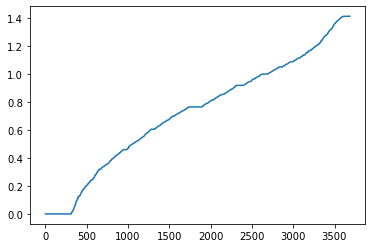

In [84]:
distances = np.sort(distances, axis=0)
# distances = distances[:,1]
plt.plot(distances)
# plt.ylim((0,0.000025))

I don't think any epsilon makes sense here.